# Diamond Price Prediction Analysis
## 1. Importing Necessary Libraries

In [226]:

import pandas as pd
import numpy as np
import pprint
import json
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_docs as tfdocs
from tensorflow import keras
from tensorflow.keras import layers, activations, Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping


## 2. Loading the Database
### Datafields : 

* carat : Diamond weight in carat

* cut : Diamond cutting quality from worst to beat(Fair,Good,Very Good,Premium,Ideal)

* color : diamond color from j(worst) to d(best)

* clarity : Diamond clarity from worst to best(I1, SI2, SI1, VS2, VS1, VVS2, VVS1, IF)

* depth : Percentage depth(mean(x,y))

* table : the width of widest point

* price : Diamond price (target variable/dependent variable)

* x : length in mm

* y : width in mm

* z : depth in mm 

In [227]:
dataset = pd.read_csv('diamonds.csv')
dataset.sample(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
22612,1.09,Very Good,F,IF,61.1,58.0,10663,6.63,6.69,4.07
52920,0.71,Premium,E,VS2,62.4,60.0,2590,5.66,5.68,3.54
18732,1.01,Very Good,D,VS2,62.7,57.0,7652,6.36,6.39,4.00
26804,2.40,Ideal,J,SI1,62.7,57.0,16687,8.60,8.50,5.36
31779,0.42,Very Good,E,SI1,62.5,55.0,773,4.80,4.83,3.01
22526,1.01,Good,E,VVS1,63.1,59.0,10567,6.31,6.34,3.99
12623,1.04,Premium,D,SI2,62.4,56.0,5292,6.50,6.45,4.04
17030,0.97,Ideal,H,VVS1,60.4,57.0,6801,6.40,6.48,3.89
13955,1.16,Very Good,G,SI1,60.7,59.0,5678,6.74,6.87,4.13
18872,1.02,Very Good,F,VS1,61.3,58.0,7740,6.46,6.52,3.98


## 3. Exploratory Data Analysis (EDA)

In [228]:
dataset.shape

(53940, 10)

In [229]:
dataset.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [230]:
dataset[['carat', 'depth', 'table']].describe()

,carat,depth,table
count,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184
std,0.474011,1.432621,2.234491
min,0.200000,43.000000,43.000000
25%,0.400000,61.000000,56.000000
50%,0.700000,61.800000,57.000000
75%,1.040000,62.500000,59.000000
max,5.010000,79.000000,95.000000


In [231]:
dataset.describe(include='all')

,carat,cut,color,clarity,depth,table,price,x,y,z
count,53940.000000,53940,53940,53940,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
unique,NaN,5,7,8,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Ideal,G,SI1,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,21551,11292,13065,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.797940,NaN,NaN,NaN,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,NaN,NaN,NaN,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,NaN,NaN,NaN,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,NaN,NaN,NaN,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,NaN,NaN,NaN,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,NaN,NaN,NaN,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000


This shows all the columns in describe function
In this dataset we notice that the min value of x,y,z columns is 0.
This indicates that there are faulty values in data.
So we have to remember later, we need to filter out those faulty data points.

### Checking the Most Common Color

In [232]:
dataset['color'].value_counts()


color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64

### Price Distribution - Boxplot

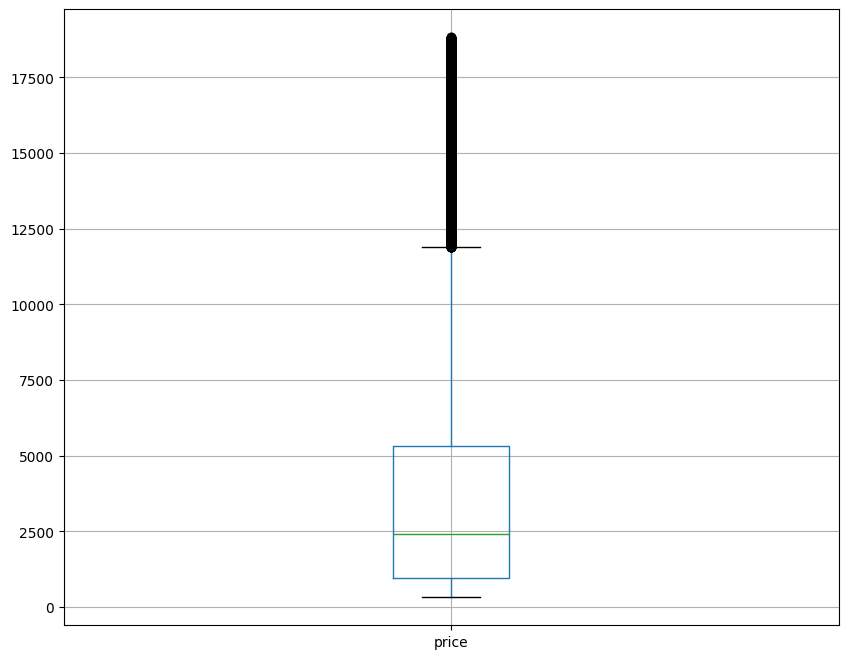

In [233]:
plt.figure(figsize=(10, 8))
dataset.boxplot('price')
plt.show()

### Price Distribution - Kernel Density Estimate (KDE)

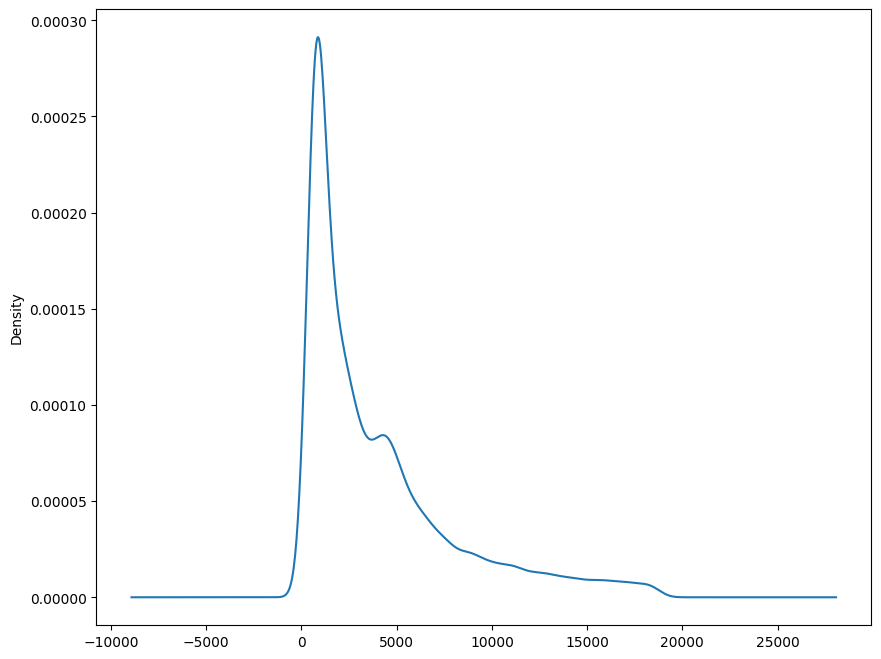

In [234]:
plt.figure(figsize=(10, 8))
dataset['price'].plot.kde()
plt.show()

### Prices in function of carats - Scatter Plot

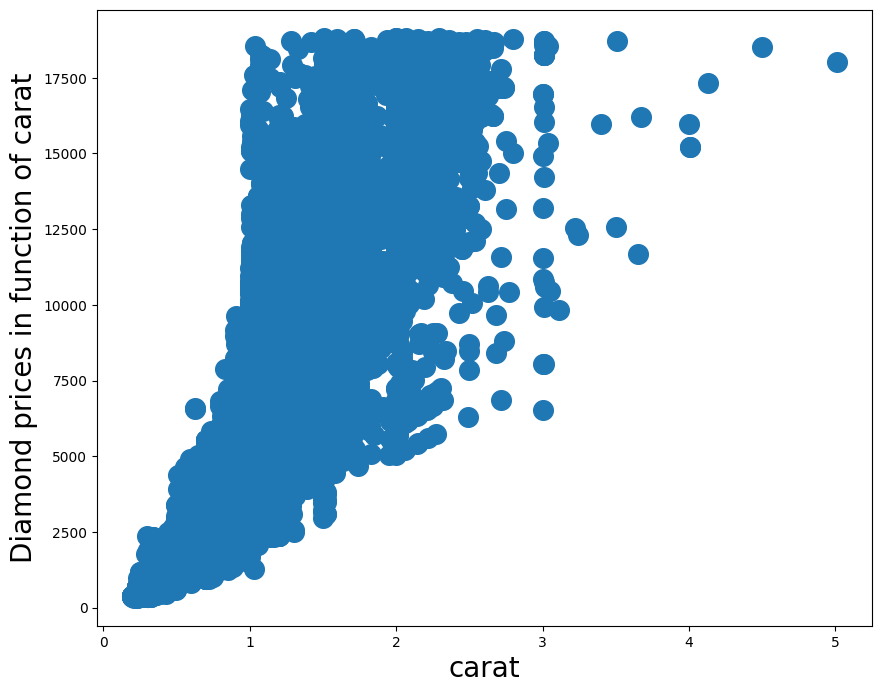

In [235]:
plt.figure(figsize=(10, 8))
plt.scatter(dataset['carat'], dataset['price'], s=200)
plt.xlabel('carat', fontsize=20)
plt.ylabel('Diamond prices in function of carat', fontsize=20)
plt.show()

### Prices in function of carats - Scatter Plot

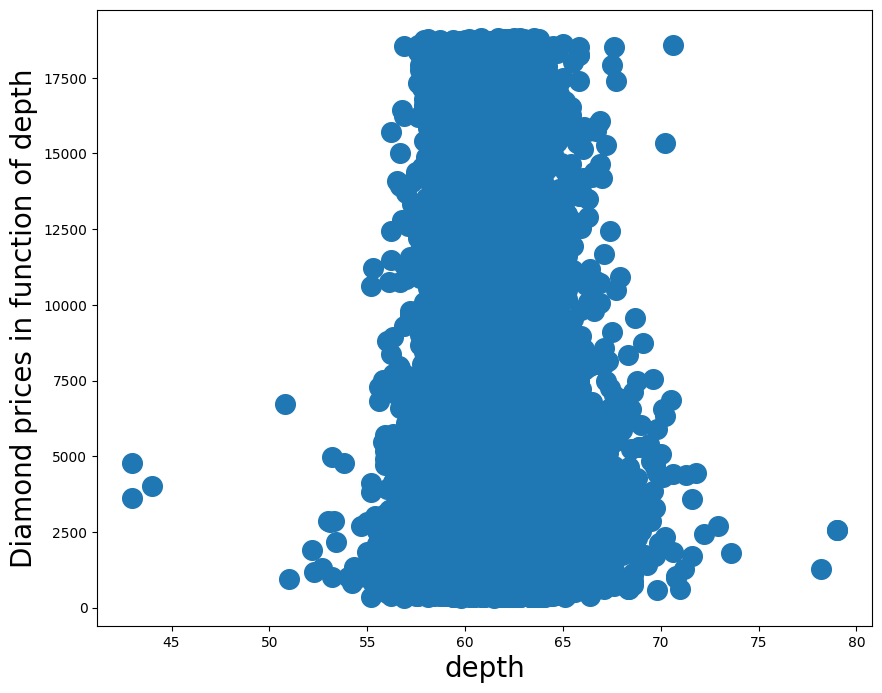

In [236]:
plt.figure(figsize=(10, 8))
plt.scatter(dataset['depth'], dataset['price'], s=200)
plt.xlabel('depth', fontsize=20)
plt.ylabel('Diamond prices in function of depth', fontsize=20)
plt.show()

## 4. Data Preprocessing
### 4.1 Handling Missing, Faulty and Non-Numeric Values
removing values with x = 0, y = 0 or z = 0

In [237]:
dataset=dataset.drop(dataset[dataset['x']==0].index)
dataset=dataset.drop(dataset[dataset['y']==0].index)
dataset=dataset.drop(dataset[dataset['z']==0].index)
dataset[['x', 'y', 'z']].describe()

,x,y,z
count,53920.000000,53920.000000,53920.000000
mean,5.731627,5.734887,3.540046
std,1.119423,1.140126,0.702530
min,3.730000,3.680000,1.070000
25%,4.710000,4.720000,2.910000
50%,5.700000,5.710000,3.530000
75%,6.540000,6.540000,4.040000
max,10.740000,58.900000,31.800000


categorical features and one-hot encoding

In [238]:
dataset['color'].unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

In [239]:
dataset['clarity'].unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

In [240]:
dataset['cut'].unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

In [241]:
categorical_features = [
    'cut', 'color', 'clarity'
]

dataset = pd.get_dummies(dataset, columns=categorical_features, drop_first=True)

bool_cols = dataset.select_dtypes(include='bool').columns
dataset[bool_cols] = dataset[bool_cols].astype(int)

dataset.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0


normalizing numeric features

In [242]:
numeric_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
scaler = StandardScaler()
dataset[numeric_features] = scaler.fit_transform(dataset[numeric_features])
dataset.head

<bound method NDFrame.head of           carat     depth     table  price         x         y         z  \
0     -1.198204 -0.174203 -1.099725    326 -1.591573 -1.539219 -1.580084   
1     -1.240417 -1.361090  1.585988    326 -1.645173 -1.662014 -1.750896   
2     -1.198204 -3.385781  3.376463    327 -1.502241 -1.460280 -1.750896   
3     -1.071566  0.454149  0.243131    334 -1.368242 -1.319943 -1.295396   
4     -1.029353  1.082501  0.243131    335 -1.243176 -1.214690 -1.124583   
...         ...       ...       ...    ...       ...       ...       ...   
53935 -0.163993 -0.662921 -0.204488   2757  0.016413  0.022027 -0.057004   
53936 -0.163993  0.942868 -1.099725   2757 -0.037186  0.013256  0.099575   
53937 -0.206205  0.733417  1.138369   2757 -0.063986 -0.048142  0.028403   
53938  0.131496 -0.523288  0.243131   2757  0.373744  0.337784  0.284622   
53939 -0.100674  0.314515 -1.099725   2757  0.087879  0.118508  0.142278   

       cut_Good  cut_Ideal  cut_Premium  ...  color_H  co

checking again to make sure there's no missing values

In [243]:
print(dataset.isnull().sum())

carat            0
depth            0
table            0
price            0
x                0
y                0
z                0
cut_Good         0
cut_Ideal        0
cut_Premium      0
cut_Very Good    0
color_E          0
color_F          0
color_G          0
color_H          0
color_I          0
color_J          0
clarity_IF       0
clarity_SI1      0
clarity_SI2      0
clarity_VS1      0
clarity_VS2      0
clarity_VVS1     0
clarity_VVS2     0
dtype: int64


### Splitting dataset into training and testing data

In [244]:
processed_features = dataset.drop(columns=['price'])
target = dataset['price']

x_train, x_test, y_train, y_test = train_test_split(processed_features, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state=1)


In [245]:
x_train.shape

(43136, 23)

In [246]:
x_test.shape

(10784, 23)

## 5. Building the Base Model

define function to build model

In [247]:
def build_model():
    model = tf.keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=[len(x_train.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

build model and show summary

In [248]:
base_model = build_model()
base_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 32)                768       
                                                                 
 dense_40 (Dense)            (None, 64)                2112      


                                                                 
 dense_41 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


checking the types of the data

In [249]:
print(x_train.dtypes)
print(y_train.dtypes)

carat            float64
depth            float64
table            float64
x                float64
y                float64
z                float64
cut_Good           int32
cut_Ideal          int32
cut_Premium        int32
cut_Very Good      int32
color_E            int32
color_F            int32
color_G            int32
color_H            int32
color_I            int32
color_J            int32
clarity_IF         int32
clarity_SI1        int32
clarity_SI2        int32
clarity_VS1        int32
clarity_VS2        int32
clarity_VVS1       int32
clarity_VVS2       int32
dtype: object
int64


making sure, again, that we do not have missing values

In [250]:
print(x_train.isna().sum())  # Check missing values
print(y_train.isna().sum())

x_train.fillna(0, inplace=True)  # Replace NaNs with 0 (or use another strategy)
y_train.fillna(0, inplace=True)

carat            0
depth            0
table            0
x                0
y                0
z                0
cut_Good         0
cut_Ideal        0
cut_Premium      0
cut_Very Good    0
color_E          0
color_F          0
color_G          0
color_H          0
color_I          0
color_J          0
clarity_IF       0
clarity_SI1      0
clarity_SI2      0
clarity_VS1      0
clarity_VS2      0
clarity_VVS1     0
clarity_VVS2     0
dtype: int64
0


Convert to NumPy Array with Correct Data Type

In [251]:
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

### 5.1 Training the Base Model

In [268]:
n_epochs = 150

base_history = base_model.fit(x_train, 
                                  y_train,
                                  epochs = n_epochs, 
                                  validation_split = 0.2, 
                                  verbose = True)

Epoch 1/150
1079/1079 [==============================] - 2s 2ms/step - loss: 349181.3438 - mae: 323.6035 - mse: 349181.3438 - val_loss: 1638226.7500 - val_mae: 344.6394 - val_mse: 1638226.7500
Epoch 2/150
1079/1079 [==============================] - 2s 2ms/step - loss: 345735.4062 - mae: 322.5976 - mse: 345735.4062 - val_loss: 1652019.7500 - val_mae: 341.2615 - val_mse: 1652019.7500
Epoch 3/150
1079/1079 [==============================] - 2s 2ms/step - loss: 345262.8750 - mae: 321.7983 - mse: 345262.8750 - val_loss: 1676615.0000 - val_mae: 341.9841 - val_mse: 1676615.0000
Epoch 4/150
1079/1079 [==============================] - 2s 2ms/step - loss: 343184.9375 - mae: 320.9787 - mse: 343184.9375 - val_loss: 1638653.6250 - val_mae: 344.0692 - val_mse: 1638653.6250
Epoch 5/150
1079/1079 [==============================] - 2s 2ms/step - loss: 341368.0000 - mae: 320.0455 - mse: 341368.0000 - val_loss: 1687207.8750 - val_mae: 336.8689 - val_mse: 1687207.8750
Epoch 6/150
1079/1079 [============

In [270]:
base_loss, base_mae, base_mse = base_model.evaluate(x_test, y_test, verbose=0)
print(f"Base Model - Mean Absolute Error: {base_mae}")
print(f"Base Model - Mean Squared Error: {base_mse}")

Base Model - Mean Absolute Error: 304.2809143066406
Base Model - Mean Squared Error: 1278718.75


## 6. Building an Enhanced Model with Dropout Layers

define function to build model

In [259]:
def build_model2():
    model = tf.keras.Sequential([
        layers.Dense(32, activation='elu', input_shape=[x_train.shape[1]]),
        layers.Dropout(0.1),
        layers.Dense(64, activation='elu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

build model and show summary

In [260]:
base_model_2 = build_model2()
base_model_2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 32)                768       
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_47 (Dense)            (None, 64)                2112      
                                                                 
 dense_48 (Dense)            (None, 32)                2080      
                                                                 
 dense_49 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


### 6.1 Training the Enhanced Base Model

In [263]:
n_epochs = 150

base_history_2 = base_model_2.fit(x_train, 
                                  y_train,
                                  epochs = n_epochs, 
                                  validation_split = 0.2, 
                                  batch_size = 32,
                                  verbose = True)

Epoch 1/150
1079/1079 [==============================] - 3s 2ms/step - loss: 409587.6562 - mae: 362.0875 - mse: 409587.6562 - val_loss: 1547715.0000 - val_mae: 328.5181 - val_mse: 1547715.0000
Epoch 2/150
1079/1079 [==============================] - 2s 2ms/step - loss: 415863.0312 - mae: 362.6701 - mse: 415863.0312 - val_loss: 1633907.3750 - val_mae: 327.4606 - val_mse: 1633907.3750
Epoch 3/150
1079/1079 [==============================] - 2s 2ms/step - loss: 411725.9062 - mae: 362.6190 - mse: 411725.9062 - val_loss: 1606103.1250 - val_mae: 329.1115 - val_mse: 1606103.1250
Epoch 4/150
1079/1079 [==============================] - 2s 2ms/step - loss: 395127.0000 - mae: 359.4587 - mse: 395127.0000 - val_loss: 1534520.6250 - val_mae: 341.7682 - val_mse: 1534520.6250
Epoch 5/150
1079/1079 [==============================] - 2s 2ms/step - loss: 414990.2812 - mae: 364.3035 - mse: 414990.2812 - val_loss: 1685707.0000 - val_mae: 331.0819 - val_mse: 1685707.0000
Epoch 6/150
1079/1079 [============

making sure that the test data is also clean, free from missing values and ready to be used for evaluation or prediction.

In [264]:
base_loss_2, base_mae_2, base_mse_2 = base_model_2.evaluate(x_test, y_test, verbose=0)
print(f"Base Model - Mean Absolute Error: {base_mae_2}")
print(f"Base Model - Mean Squared Error: {base_mse_2}")

Base Model - Mean Absolute Error: 297.3165283203125
Base Model - Mean Squared Error: 1393526.5


## 7. Comparing model performances

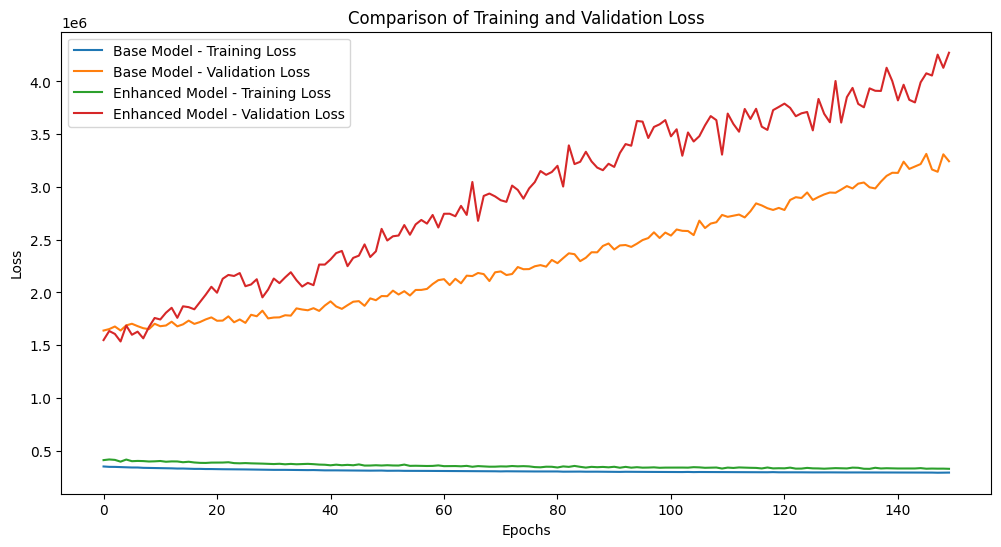

In [271]:
plt.figure(figsize=(12, 6))
plt.plot(base_history.history['loss'], label='Base Model - Training Loss')
plt.plot(base_history.history['val_loss'], label='Base Model - Validation Loss')
plt.plot(base_history_2.history['loss'], label='Enhanced Model - Training Loss')
plt.plot(base_history_2.history['val_loss'], label='Enhanced Model - Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparison of Training and Validation Loss')
plt.show()

In [272]:
print(f"Base Model MAE: {base_mae}")
print(f"Enhanced Model MAE: {base_mae_2}")

Base Model MAE: 304.2809143066406
Enhanced Model MAE: 297.3165283203125


## 8. Creating a Custom Dense Layer

In [273]:
class MyDense(layers.Layer):
    
    def __init__(self, units, activation=None, **kwargs):
        
        super(MyDense, self).__init__(**kwargs)
        
        self.units = units
        self.activation = activations.get(activation)
        
    def build(self, input_shape):
        input_dim = input_shape[-1]
        
        self.kernel = self.add_weight(shape=(input_dim, self.units))
        
    def call(self, inputs):
        output = tf.matmul(inputs, self.kernel)
        
        if self.activation is not None:
            output = self.activation(output)
        
        return output
    
    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        
        return tuple(output_shape)
    
    def get_config(self):
        config = super(MyDense, self).get_config()
        
        current_config = {
            'units': self.units,
            'activation': activations.serialize(self.activation)
        }
        
        config.update(current_config)

        return config

### 8.1 Building and compiling

In [277]:
def build_model3():
    
    model = tf.keras.Sequential([
        MyDense(64, activation='elu', input_shape=[x_train.shape[1]]),
        MyDense(32, activation='elu'),
        
        layers.Dropout(0.2),
        
        MyDense(16, activation='elu'),
        MyDense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [278]:
sequential_model = build_model3()

sequential_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_dense_4 (MyDense)        (None, 64)                1472      
                                                                 
 my_dense_5 (MyDense)        (None, 32)                2048      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 my_dense_6 (MyDense)        (None, 16)                512       
                                                                 
 my_dense_7 (MyDense)        (None, 1)                 16        
                                                                 
Total params: 4,048
Trainable params: 4,048
Non-trainable params: 0
_________________________________________________________________


checking model layers

In [279]:
sequential_model.layers

## 9. Training the Model with early stopping

In [280]:
n_epochs = 1000

# Use EarlyStopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
training_hist_seq = sequential_model.fit(
    x_train, y_train,
    epochs=n_epochs,
    validation_split=0.2,
    verbose=1,  # Show progress bar instead of 'tfdocs.modeling.EpochDots()'
    callbacks=[early_stopping]  # Replace EpochDots with EarlyStopping
)

Epoch 1/1000
1079/1079 [==============================] - 3s 2ms/step - loss: 15599796.0000 - mae: 2464.0417 - mse: 15599796.0000 - val_loss: 2476360.2500 - val_mae: 1026.9360 - val_mse: 2476360.2500
Epoch 2/1000
1079/1079 [==============================] - 2s 2ms/step - loss: 2295596.7500 - mae: 992.7560 - mse: 2295596.7500 - val_loss: 1741953.5000 - val_mae: 767.7241 - val_mse: 1741953.5000
Epoch 3/1000
1079/1079 [==============================] - 2s 2ms/step - loss: 1870648.8750 - mae: 835.6373 - mse: 1870648.8750 - val_loss: 1412766.6250 - val_mae: 651.4805 - val_mse: 1412766.6250
Epoch 4/1000
1079/1079 [==============================] - 2s 2ms/step - loss: 1634898.7500 - mae: 774.7468 - mse: 1634898.7500 - val_loss: 1096064.6250 - val_mae: 612.2676 - val_mse: 1096064.6250
Epoch 5/1000
1079/1079 [==============================] - 2s 2ms/step - loss: 1502944.3750 - mae: 750.7233 - mse: 1502944.3750 - val_loss: 940934.0625 - val_mae: 584.6680 - val_mse: 940934.0625
Epoch 6/1000
1079/

## 10. Making Predictions and Visualization

In [294]:
sequential_loss, sequential_mae, sequential_mse = sequential_model.evaluate(x_test, y_test, verbose=0)
print(f"Base Model - Mean Absolute Error: {sequential_mae}")
print(f"Base Model - Mean Squared Error: {sequential_mse}")

Base Model - Mean Absolute Error: 328.19500732421875
Base Model - Mean Squared Error: 390556.28125


337/337 [==============================] - 0s 998us/step


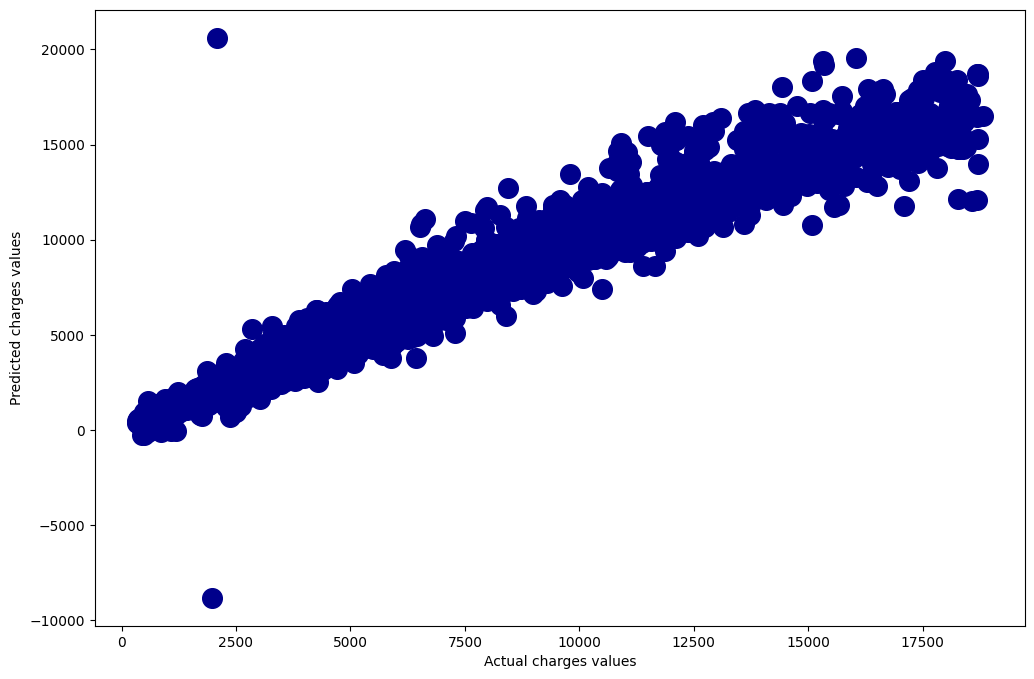

In [282]:
y_pred = sequential_model.predict(x_test).flatten()

plt.figure(figsize=(12, 8))

plt.scatter(y_test, y_pred, s=200, c='darkblue')

plt.xlabel('Actual charges values')
plt.ylabel('Predicted charges values')
plt.show()

In [283]:
r2_score(y_test, y_pred)

0.973996102809906

# 11. Creating a Custom Regression Model

In [284]:
class CustomRegressionModel(tf.keras.Model):

    def __init__(self, input_shape, layer_units=[8, 4], \
                 activation='relu'):

        super(CustomRegressionModel, self).__init__()

        assert len(layer_units) > 0

        self.input_layer = MyDense(layer_units[0],
                                   activation=activation,
                                   input_shape=[input_shape])

        self.hidden_layers = []

        for i in range(1, len(layer_units)):
            self.hidden_layers.append(MyDense(layer_units[i],
                                              activation=activation))

        self.output_layer = MyDense(1)

    def call(self, input_tensor):

        x = self.input_layer(input_tensor)

        for layer in self.hidden_layers:
            x = layer(x)

        result = self.output_layer(x)

        return result

#### Initializing and Checking the Custom Model

In [286]:
custom_model = CustomRegressionModel(x_train.shape[1], [64, 32, 16], 'elu')

custom_model(tf.zeros([5, x_train.shape[1]]))

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [287]:
custom_model.layers

In [288]:
custom_model.summary()

Model: "custom_regression_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_dense_8 (MyDense)        multiple                  1472      
                                                                 
 my_dense_9 (MyDense)        multiple                  2048      
                                                                 
 my_dense_10 (MyDense)       multiple                  512       
                                                                 
 my_dense_11 (MyDense)       multiple                  16        
                                                                 
Total params: 4,048
Trainable params: 4,048
Non-trainable params: 0
_________________________________________________________________


In [289]:
optimizer = tf.keras.optimizers.RMSprop(0.001)

custom_model.compile(loss='mse',
                     optimizer=tf.keras.optimizers.RMSprop(0.001),
                     metrics=['mse'])

## 12. Training & Visualizing

In [291]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

n_epochs = 150

X_train_numeric = np.array(x_train, dtype=np.float32)
y_train_numeric = np.array(y_train, dtype=np.float32)

training_hist = custom_model.fit(X_train_numeric,
                                 y_train_numeric,
                                 epochs=n_epochs,
                                 validation_split=0.2,
                                 verbose=False,
                                 callbacks=[tfdocs.modeling.EpochDots()])



Epoch: 0, loss:331822.6562,  mse:331822.6562,  val_loss:768594.6250,  val_mse:768594.6250,  
....................................................................................................
Epoch: 100, loss:299501.5625,  mse:299501.5625,  val_loss:2939284.0000,  val_mse:2939284.0000,  
..................................................

#### Visualizing training history

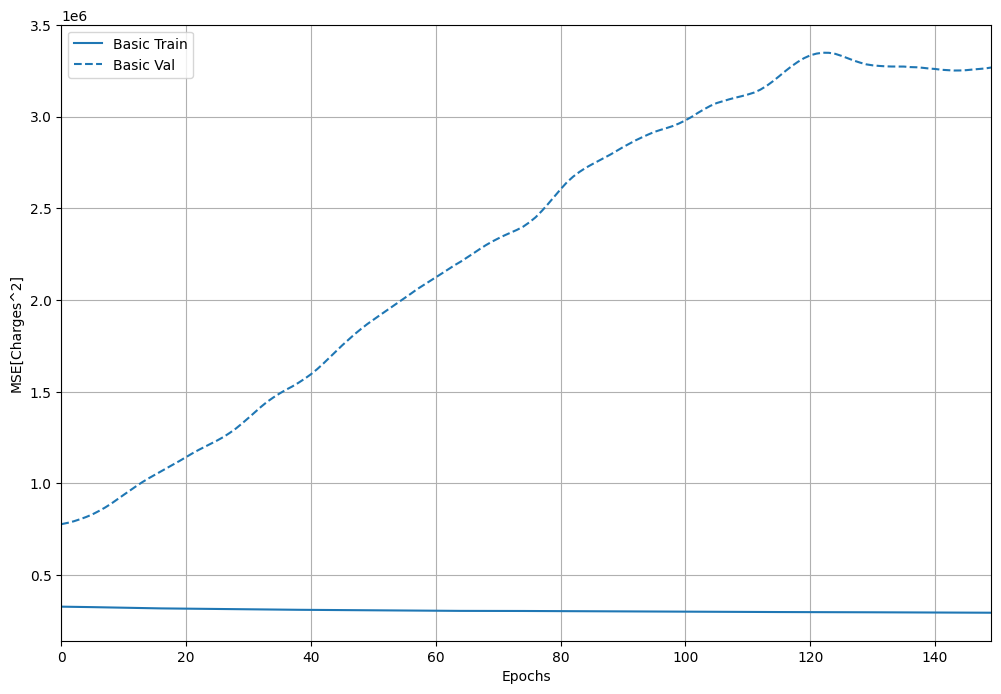

In [296]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plt.figure(figsize=(12, 8))
plotter.plot({'Basic': training_hist}, metric="mse")
plt.ylabel('MSE[Charges^2]')
plt.show()

#### Preparing `x_test` for Predictions

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Check if x_test is still a Pandas DataFrame before converting
if isinstance(x_test, pd.DataFrame):  
    print(x_test.dtypes)

    # Step 2: Convert object columns to numeric if necessary
    x_test = x_test.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, replace invalid data with NaN

    # Step 3: Handle missing values if any
    print(x_test.isna().sum())  # Check for missing values
    x_test.fillna(0, inplace=True)  # Fill NaNs with 0 (or another strategy)

# Step 4: Ensure the data is in the correct format
x_test = np.array(x_test, dtype=np.float32)  # Convert to NumPy array only once


Making Predictions with the custom model

In [298]:
y_pred = custom_model.predict(x_test).flatten()

337/337 [==============================] - 1s 1ms/step


#### Visualizing predictions

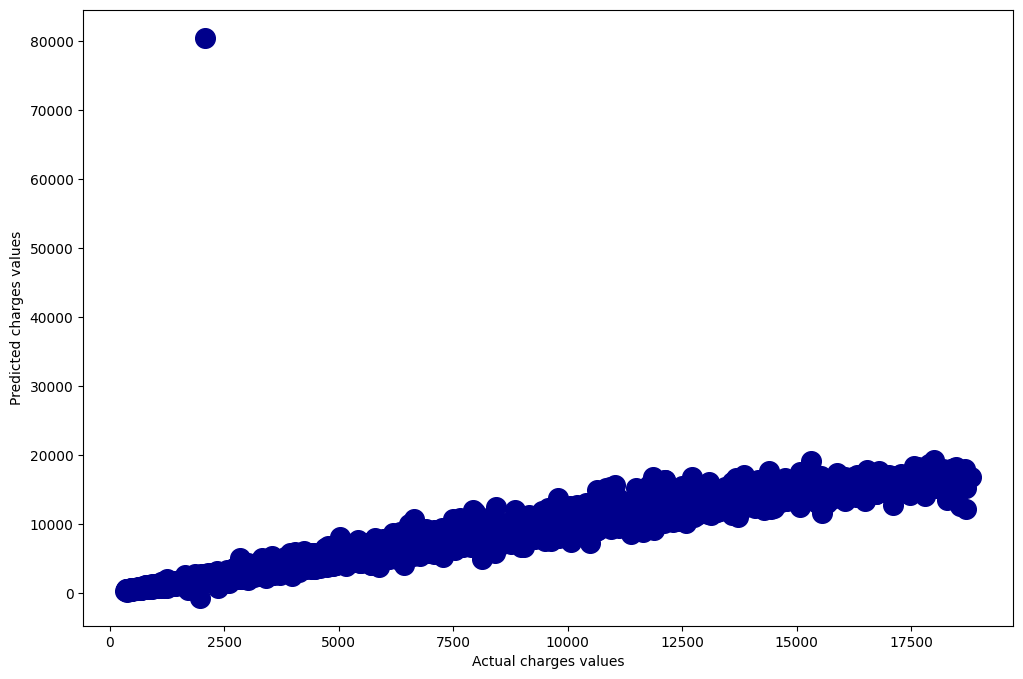

In [299]:
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, s=200, c='darkblue')
plt.xlabel('Actual charges values')
plt.ylabel('Predicted charges values')
plt.show()


### Evaluating Model Performance with R² Score

In [300]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9430447816848755

In [ ]:
custom_model.save_weights('my_models/custom_model.weights.h5')

# 13. Loading the Model Weights into a New Model

In [303]:
new_model = CustomRegressionModel(x_train.shape[1], [64, 32, 16], 'elu')

# Initialize the model by calling it with dummy input
new_model(tf.zeros([5, x_train.shape[1]]))

optimizer = tf.keras.optimizers.RMSprop(0.001)

new_model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.RMSprop(0.001),
                  metrics=['mse'])

new_model.load_weights('my_models/custom_model.weights.h5')


#### Predictions & R2 score

In [305]:
y_pred_new = new_model.predict(x_test) 
r2_score(y_test, y_pred_new)

337/337 [==============================] - 1s 2ms/step


0.9430447816848755